In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
from sklearn.dummy import DummyRegressor

import statsmodels.api as sm

%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')




In [2]:
# Import data: 
df = pd.read_csv('./datasets/stc_data_cleaned.csv', parse_dates=['date'], dayfirst=True)
df = df.drop(['Unnamed: 0'], axis=1)

In [3]:
# R^2 of Public Accuracy of the exact finishing position is low

X = df[['public_prob']] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 -7.794604047766618
Coefficients: 
 [0.17229501]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     1119.
Date:                Mon, 22 Jul 2019   Prob (F-statistic):          7.85e-233
Time:                        21:05:42   Log-Likelihood:                -32587.
No. Observations:               10233   AIC:                         6.518e+04
Df Residuals:                   10231   BIC:                         6.519e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(-6.5, 0)

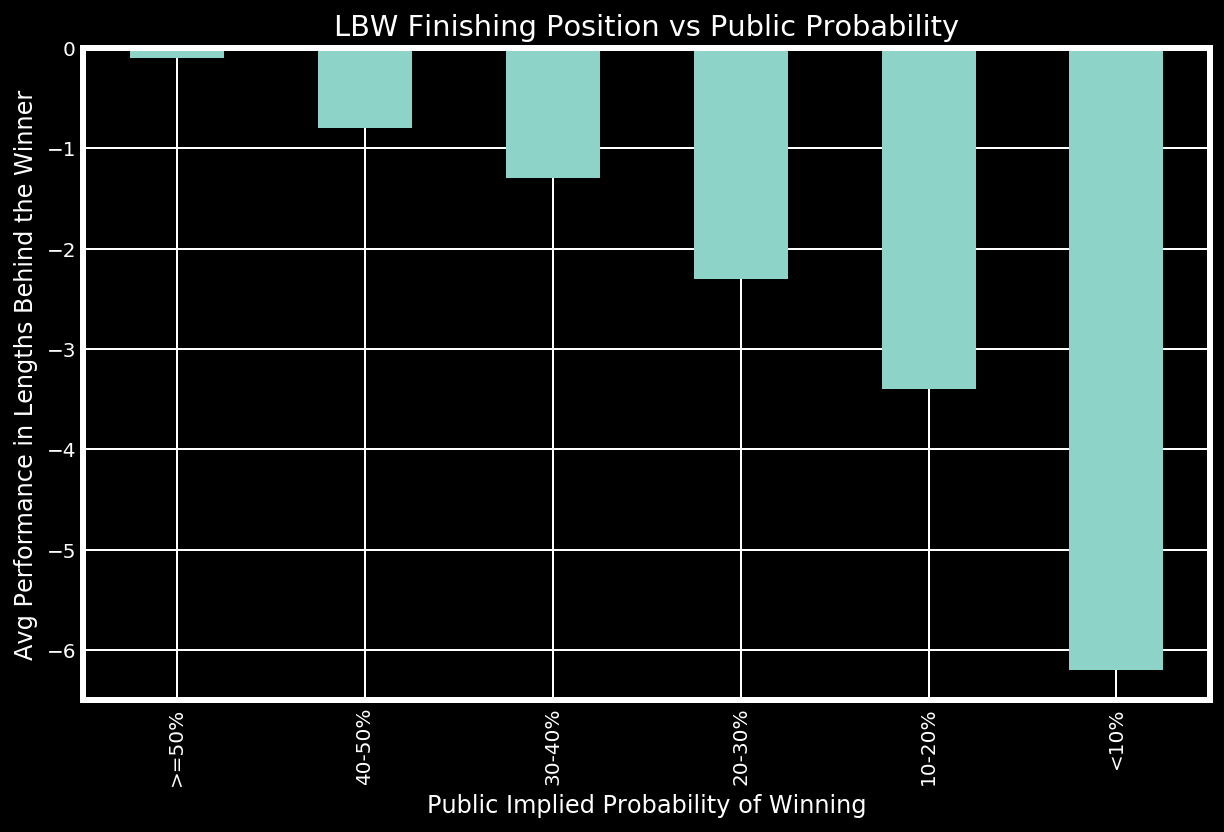

In [4]:
# However, their ability to rank the horses finishing position looks reasonably good.

# histogram on 'binned_public_prob' & 'binned_lbw':
plt.style.use('dark_background')
odds_bin_ranges = [0, 10.5, 12.5, 16.5, 25.5, 50.5, 2000]
odds_bin_names = ['>=50%', '40-50%', '30-40%', '20-30%', '10-20%', '<10%']

df['binned_prob_win_div_3'] = pd.cut((df['win_div_3']), bins=odds_bin_ranges,labels=odds_bin_names)

public_prob_perf = df[['lbw', 'binned_prob_win_div_3']].groupby('binned_prob_win_div_3').agg('median')

plt.style.use('dark_background')
plt.title('LBW Finishing Position vs Public Probability')
#plt.xlabel('Public Implied Probability')
plt.ylabel('Avg Performance in Lengths Behind the Winner')

plt.style.use('dark_background')
public_prob_perf['lbw'].plot.bar()
#plt.tight_layout()
#plt.figtext(0.995, 0.01, u'\u00a9 Charles Spencer 2019', ha='right', va='bottom')
plt.gcf().set_size_inches(9, 6)
plt.xlabel('Public Implied Probability of Winning')

#plt.xlim(0, -20)  
plt.ylim(-6.5, 0) 

In [5]:
# Groupby Favorite and Longshot. Table showing results of Step One:

# Creating a new dataframe: eff_mkt (Efficient Market) with the binned wagering statistics 
# to look for any favorite/longshot bias.


eff_mkt = df[['lbw', 'win_div_3', 'binned_win_div_3', 'total_count', 'win_count', 'total_wager', 
              'return_wager', 'loss_rebate', 'profit_loss']].groupby('binned_win_div_3').agg('sum')

eff_mkt = eff_mkt.assign(profit_loss_percent = eff_mkt['profit_loss'] / eff_mkt['total_wager'])
eff_mkt = eff_mkt.assign(win_percent = eff_mkt['win_count'] / eff_mkt['total_count'])
eff_mkt = eff_mkt.assign(lbw_avg = eff_mkt['lbw'] / eff_mkt['total_count'])
eff_mkt = eff_mkt.assign(win_div_3_avg = eff_mkt['win_div_3'] / eff_mkt['total_wager'])

#Reorder columns:
cols = ['total_count', 'win_count', 'win_percent', 'total_wager', 
        'return_wager', 'loss_rebate', 'profit_loss', 'profit_loss_percent']
eff_mkt = eff_mkt[cols]

eff_mkt.rename(index={'$6-20; Prob. >=25%':'Prob. >=25%','$21+; Prob. <25%':'Prob. <25%'}, inplace=True)

#eff_mkt.head()

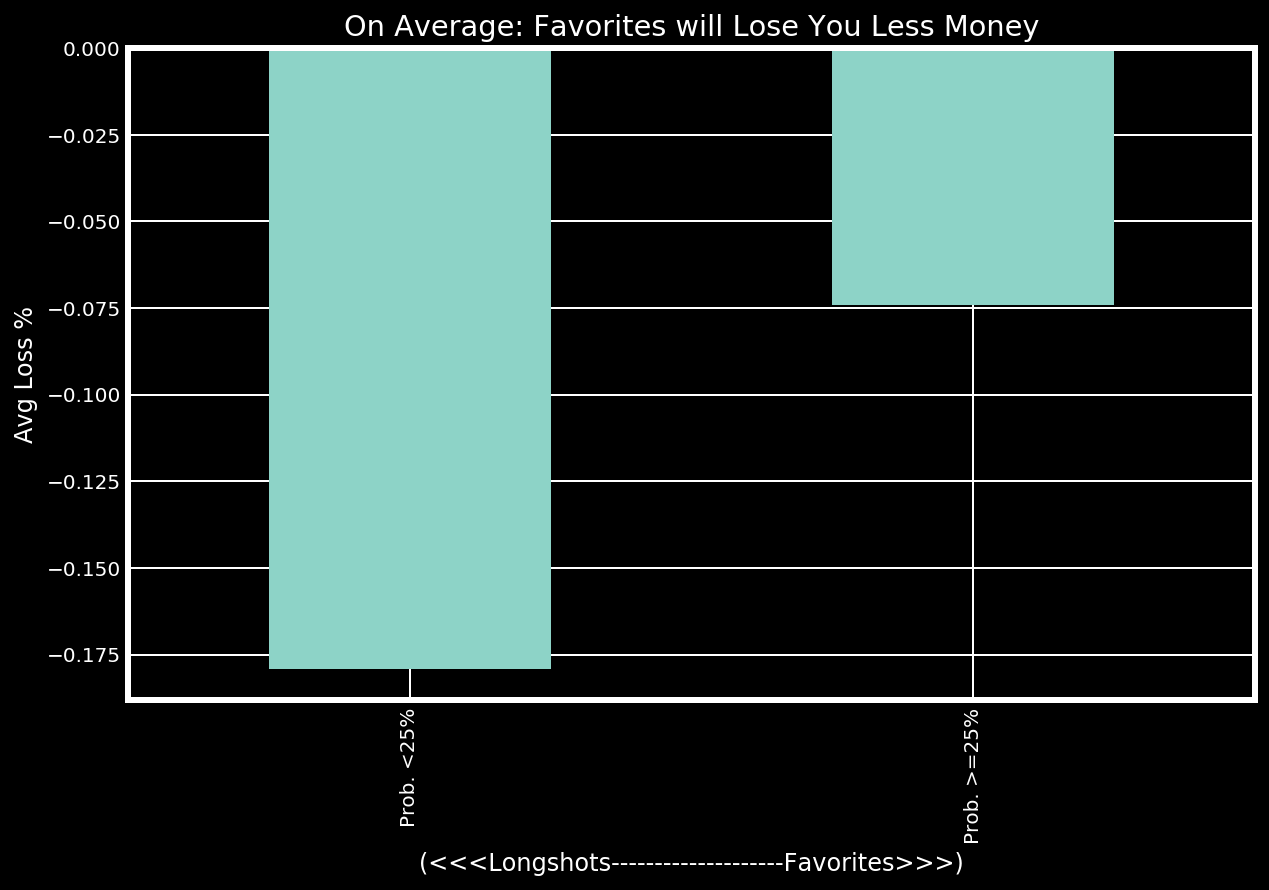

In [6]:
# However, there remains a well documented wagering bias of longshots being overbet relative to their 
# probability of winning, on average.   

plt.style.use('dark_background')

plt.style.use('dark_background')
eff_mkt['profit_loss_percent'].plot.bar()
#eff_mkt.invert_xaxis()
plt.title('On Average: Favorites will Lose You Less Money')
plt.xlabel('(<<<Longshots--------------------Favorites>>>)')
plt.ylabel('Avg Loss %')

plt.gcf().set_size_inches(9, 6)

#if eff_mkt.xaxis_inverted():
#    eff_mkt.invert_xaxis()

#eff_mkt[["a", "a*1.1"]].sort("a").plot(ax=ax, x="a")

In [7]:
eff_mkt.head()

,total_count,win_count,win_percent,total_wager,return_wager,loss_rebate,profit_loss,profit_loss_percent
binned_win_div_3,,,,,,,,
Prob. <25%,9029,526,0.058257,45145,32799,4251.5,-8094.5,-0.179300
Prob. >=25%,1204,360,0.299003,6020,5152,422.0,-446.0,-0.074086


In [8]:
# Import data: 
df = pd.read_csv('./datasets/stc_data_engineered.csv', parse_dates=['date'], dayfirst=True)
df = df.drop(['Unnamed: 0'], axis=1)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#df.head()

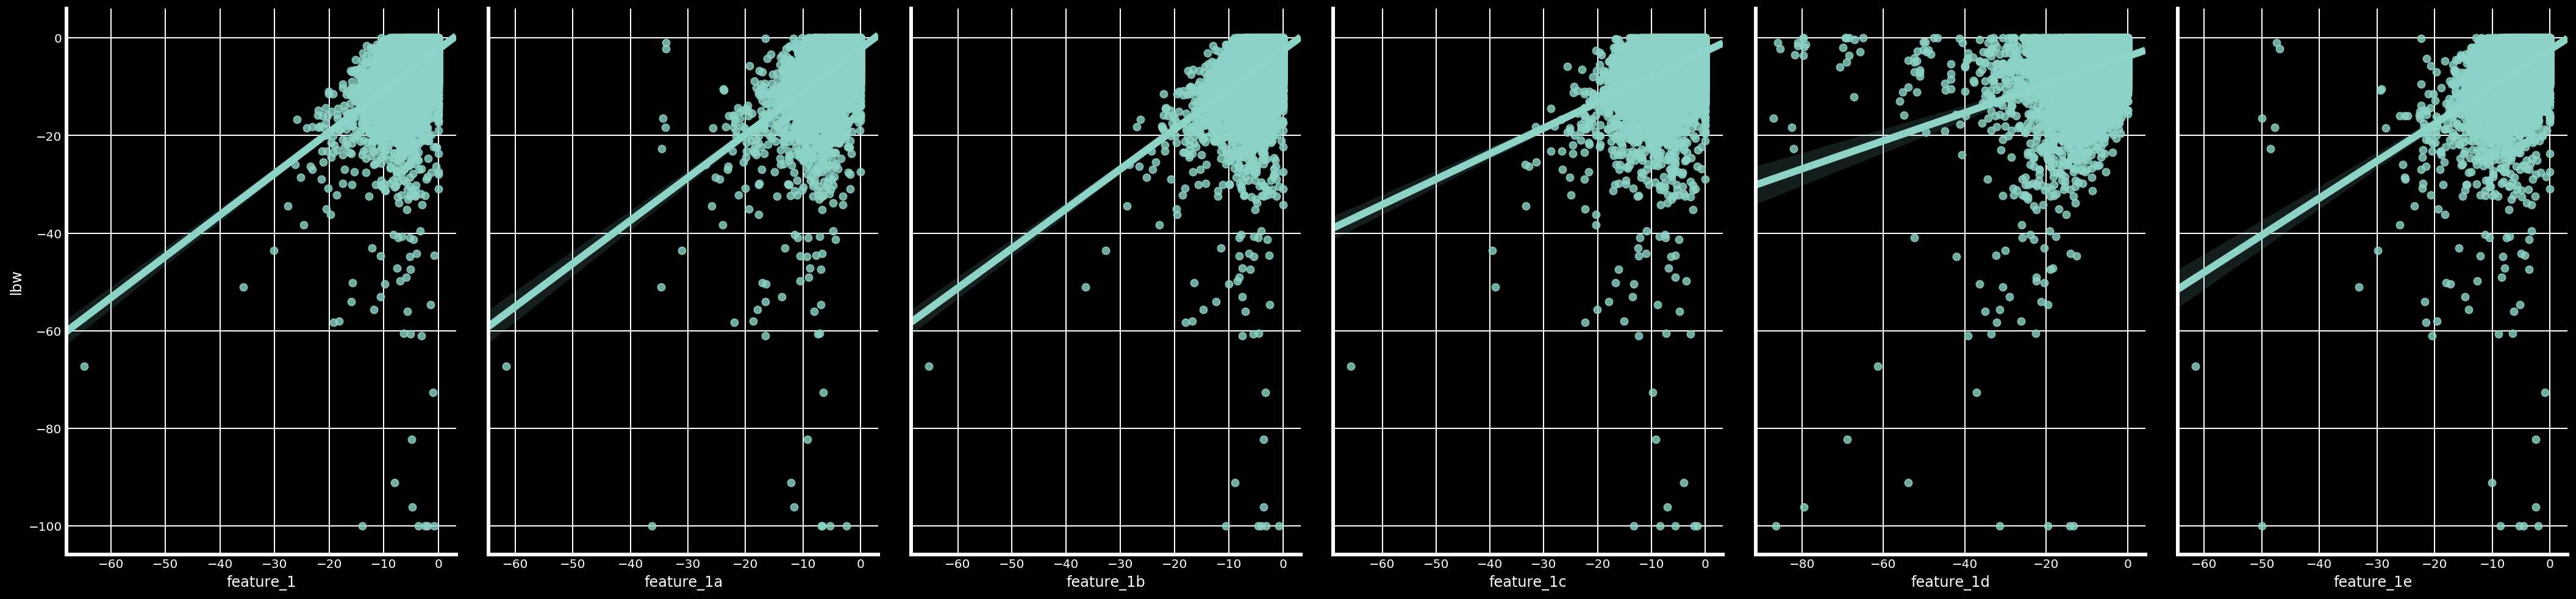

In [9]:
# So our aim is: 1) to build a predictive model which can forecast the finishing positions better than the public
# and 2) avoid betting on longshots (paying over $28 for a $5 wager) where the hurdle rates are higher.

# visualize the relationship between the features we plan on using and the response using scatterplots
plt.style.use('dark_background')
sns.pairplot(df, x_vars=['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e'],
             y_vars='lbw', height=7, aspect=0.7, kind='reg')

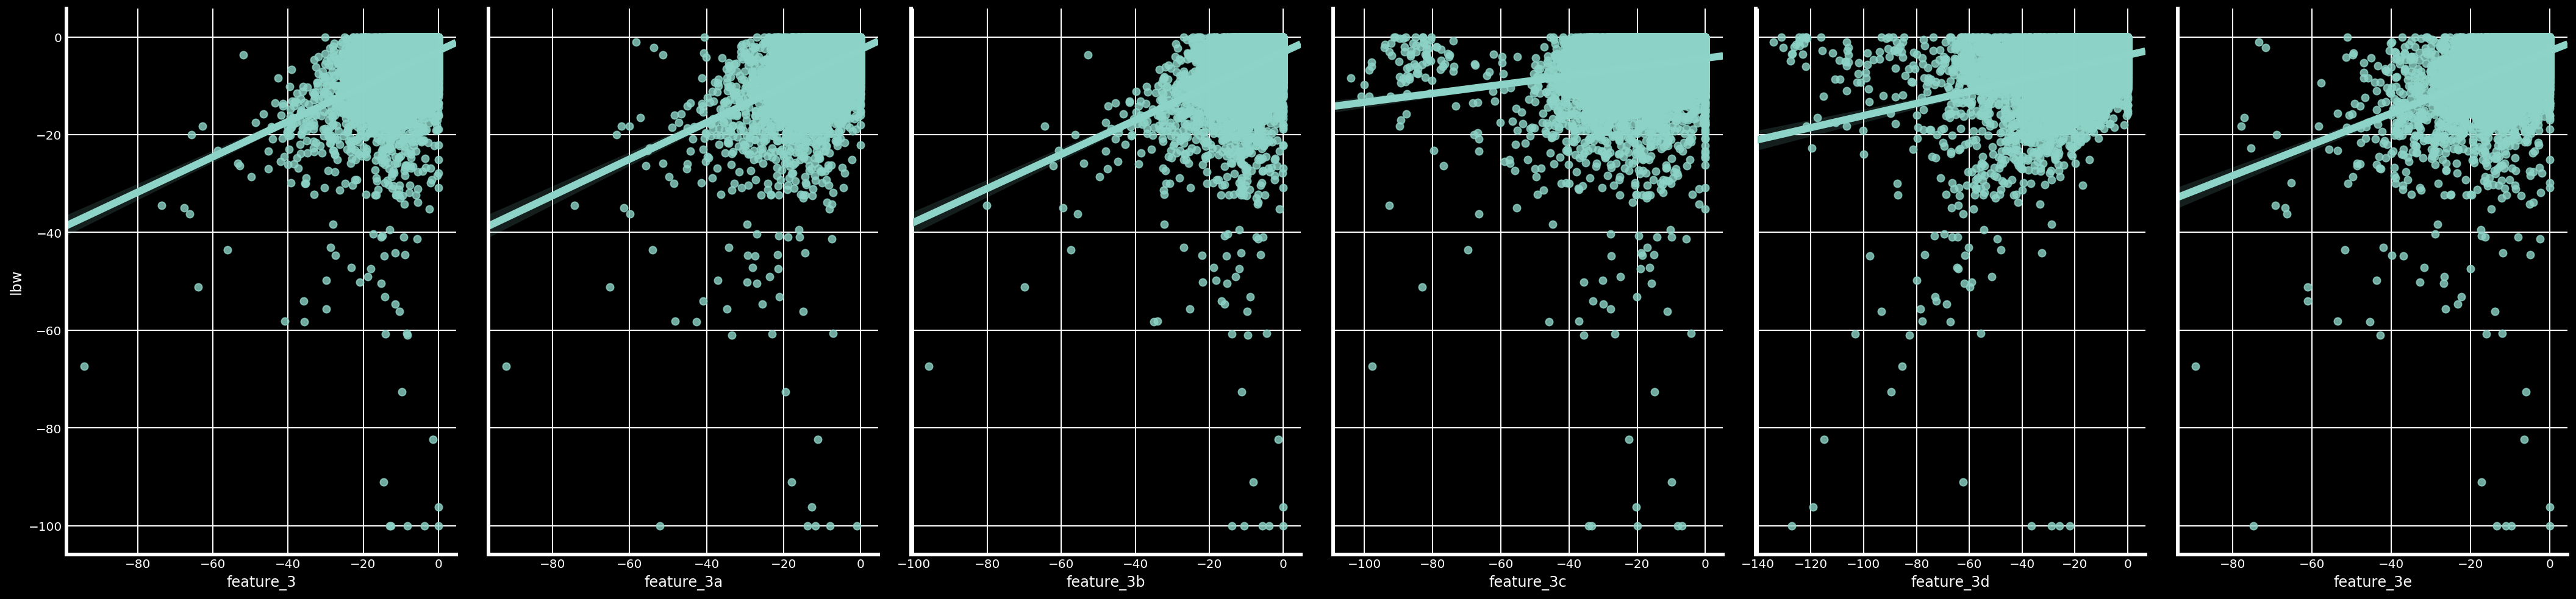

In [10]:
# visualize the relationship between the features we plan on using and the response using scatterplots
plt.style.use('dark_background')
sns.pairplot(df, x_vars=['feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e'],
             y_vars='lbw', height=7, aspect=0.7, kind='reg')

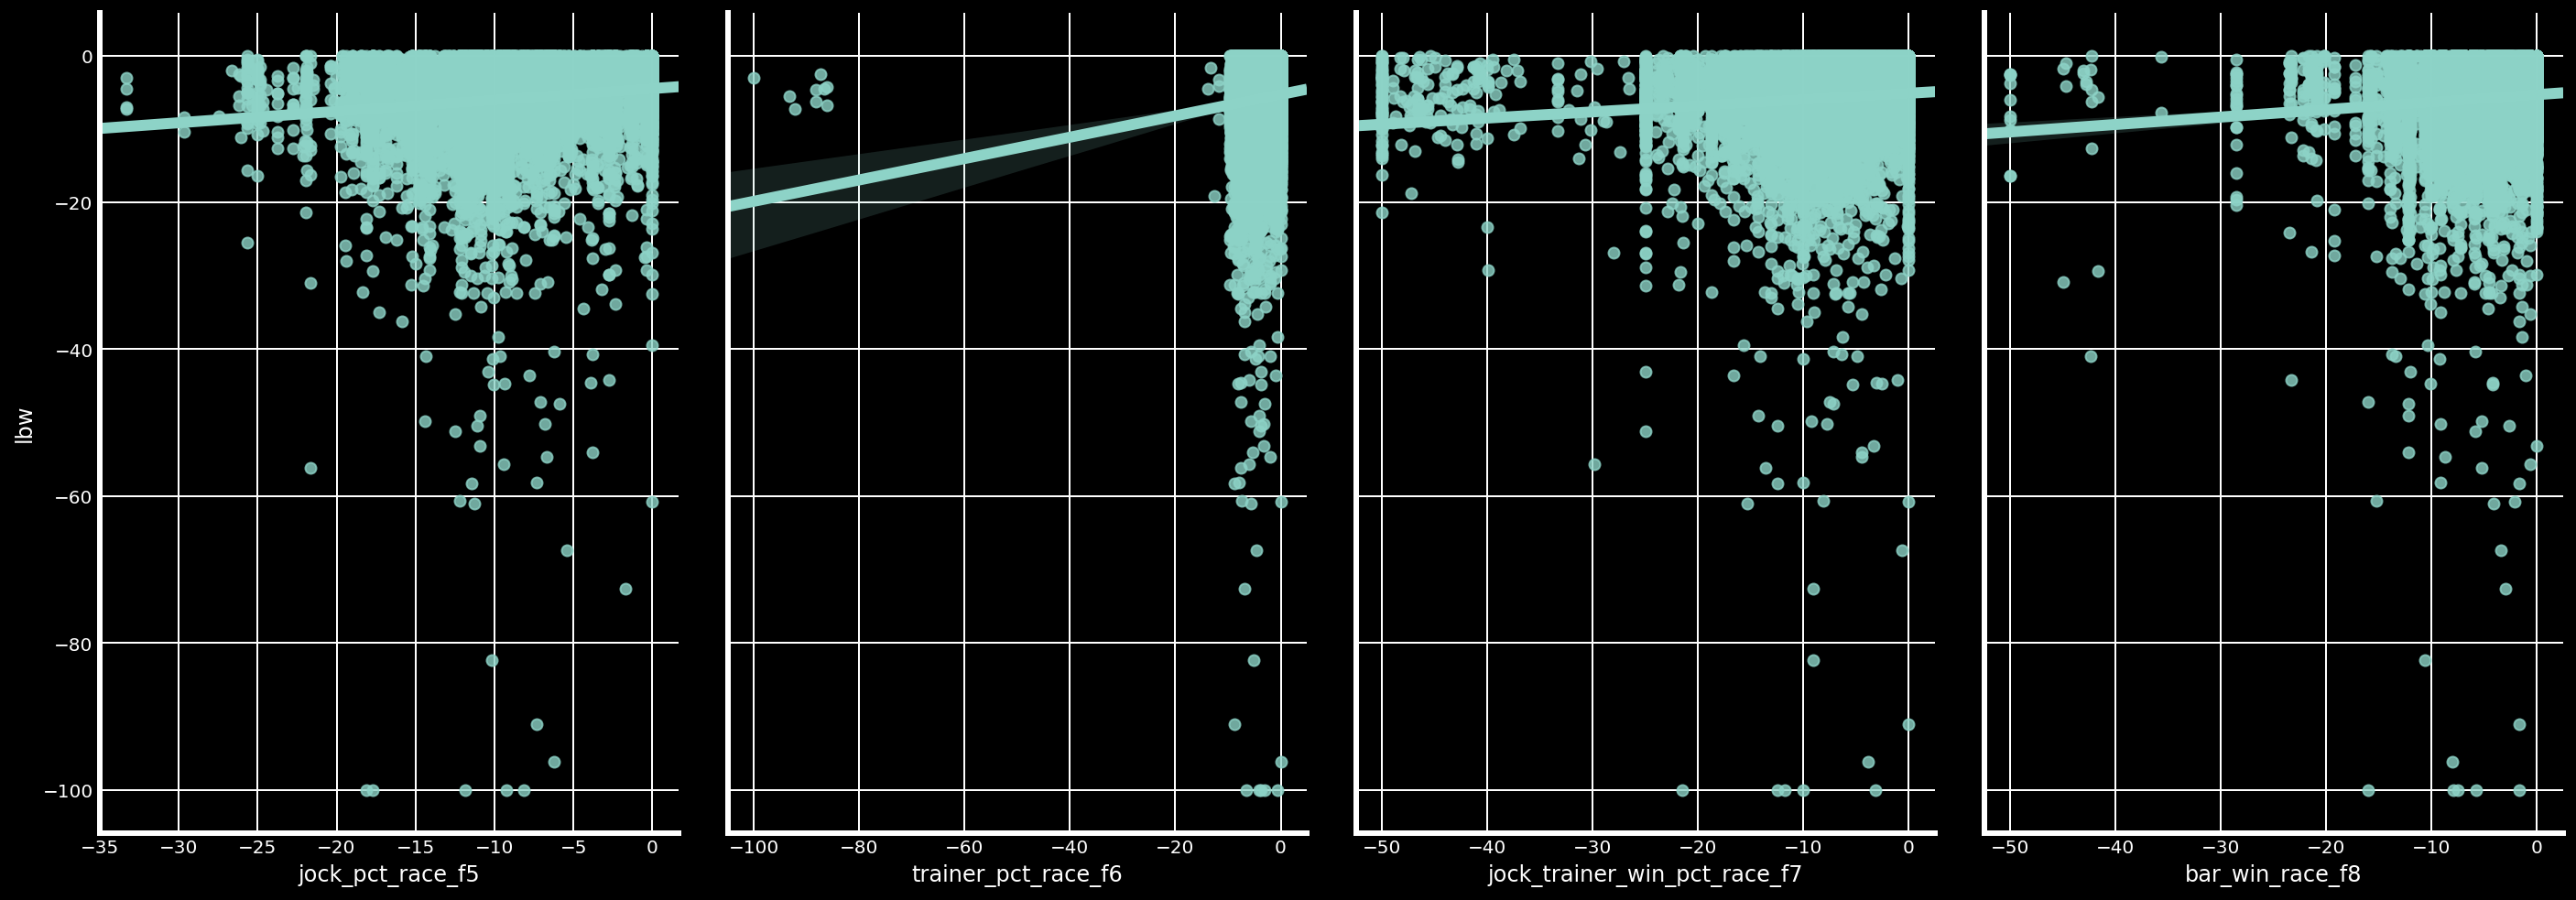

In [11]:
# visualize the relationship between the features we plan on using and the response using scatterplots
plt.style.use('dark_background')
sns.pairplot(df, x_vars=['jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7',
                        'bar_win_race_f8'],
             y_vars='lbw', height=7, aspect=0.7, kind='reg')

In [12]:
# using all features 1-8:
X = df[['feature_1', 'feature_1a', 'feature_1b', 'feature_1c', 'feature_1d', 'feature_1e',
        'feature_3', 'feature_3a', 'feature_3b', 'feature_3c', 'feature_3d', 'feature_3e',
        'jock_pct_race_f5', 'trainer_pct_race_f6', 'jock_trainer_win_pct_race_f7', 'bar_win_race_f8',
        
       ]] 
y = df['lbw']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 0.07180468569719434
Coefficients: 
 [ 0.07190777  0.11476629  0.18751311  0.09898789  0.06707182  0.13892371
  0.03384781  0.0121549  -0.00710318 -0.00141769  0.02184374  0.06619023
  0.03569542  0.03159983  0.03279345  0.10495907]
                            OLS Regression Results                            
Dep. Variable:                    lbw   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     258.1
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:05:55   Log-Likelihood:                -31381.
No. Observations:               10233   AIC:                         6.280e+04
Df Residuals:                   10216   BIC:                         6.292e+04
Df Model:                          16                                         
Covariance Type:            nonrobust       

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [13]:
# Import race card data: 
df_rc = pd.read_csv('./datasets/stc_data_race_card_analyzed.csv', parse_dates=['date'], dayfirst=True)
df_rc = df_rc.drop(['Unnamed: 0'], axis=1)


In [14]:
df_rc

,date,race,horse_name,jockey,horse_no,race_lbw_pred,race_win_div_pred
0,2019-07-21,1,MAJESTIC,M ZAKI,2,-0.965476,53.250000
1,2019-07-21,1,PRINCE PEGASUS,APP M NIZAR,3,-0.218611,35.500000
2,2019-07-21,1,HERO STAR,B MELHAM,4,-0.597216,47.333333
3,2019-07-21,1,COMECATCHME,J AZZOPARDI,6,-10.636869,2130.000000
4,2019-07-21,1,HERO IN THE WIND,S NOH,7,-0.494644,42.600000
5,2019-07-21,1,PLATO,APP WH KOK,8,-0.036538,26.625000
6,2019-07-21,1,SILVER JOY,APP N ZYRUL,9,-2.774230,106.500000
7,2019-07-21,1,YULONG FIRE,M RODD,10,-5.180187,426.000000
8,2019-07-21,1,ZMAN,C MURRAY,11,-4.650100,213.000000
9,2019-07-21,1,BROADWAY SUCCESS,R WOODWORTH,12,-4.767560,426.000000


In [15]:
# use our model to predict lbw_pred

df_rc[['date', 'race', 'horse_name', 'race_lbw_pred', 'race_win_div_pred']].head(14)

,date,race,horse_name,race_lbw_pred,race_win_div_pred
0,2019-07-21,1,MAJESTIC,-0.965476,53.250000
1,2019-07-21,1,PRINCE PEGASUS,-0.218611,35.500000
2,2019-07-21,1,HERO STAR,-0.597216,47.333333
3,2019-07-21,1,COMECATCHME,-10.636869,2130.000000
4,2019-07-21,1,HERO IN THE WIND,-0.494644,42.600000
5,2019-07-21,1,PLATO,-0.036538,26.625000
6,2019-07-21,1,SILVER JOY,-2.774230,106.500000
7,2019-07-21,1,YULONG FIRE,-5.180187,426.000000
8,2019-07-21,1,ZMAN,-4.650100,213.000000
9,2019-07-21,1,BROADWAY SUCCESS,-4.767560,426.000000


In [17]:
# Top focus on top 3 picks & Fair-odds in each race for the day:

#df_rc_bets = df_rc[['date', 'race',  'horse_name', 'horse_no', 'jockey', 
#                    'race_lbw_pred',  'race_win_div_pred']]

#df_rc_bets.round({'races_run': 0, "race_lbw_pred":1, "race_prob_pred":1, "race_win_div_pred":0}) 

#df_rc_bets.sort_values(['race','race_win_div_pred'],ascending=True).groupby('race').head(3).round(0)


,date,race,horse_name,horse_no,jockey,race_lbw_pred,race_win_div_pred
5,2019-07-21,1,PLATO,8,APP WH KOK,-0.0,27.0
10,2019-07-21,1,GOLDEN THUNDER,13,B PINHEIRO,0.0,27.0
1,2019-07-21,1,PRINCE PEGASUS,3,APP M NIZAR,-0.0,36.0
14,2019-07-21,2,ON LINE,1,V DURIC,0.0,8.0
15,2019-07-21,2,FOREVER WIN,2,B THOMPSON,-2.0,31.0
18,2019-07-21,2,DUXTON,5,W PIKE,-5.0,62.0
32,2019-07-21,3,DUSSELDORF,5,M RODD,0.0,23.0
34,2019-07-21,3,TURF PRINCESS,7,B MELHAM,-0.0,23.0
35,2019-07-21,3,GREEN STAR,8,APP WH KOK,-1.0,40.0
46,2019-07-21,4,GALILEO'S APPROACH,5,M KELLADY,0.0,30.0


In [18]:
# Import data: 
#df = pd.read_csv('myfile.csv', parse_dates=['Date'], dayfirst=True)
accumualted_profit_loss = pd.read_csv('./datasets/accumualted_profit_loss.csv', parse_dates=['date'
                                                                                            ], dayfirst=True)
  

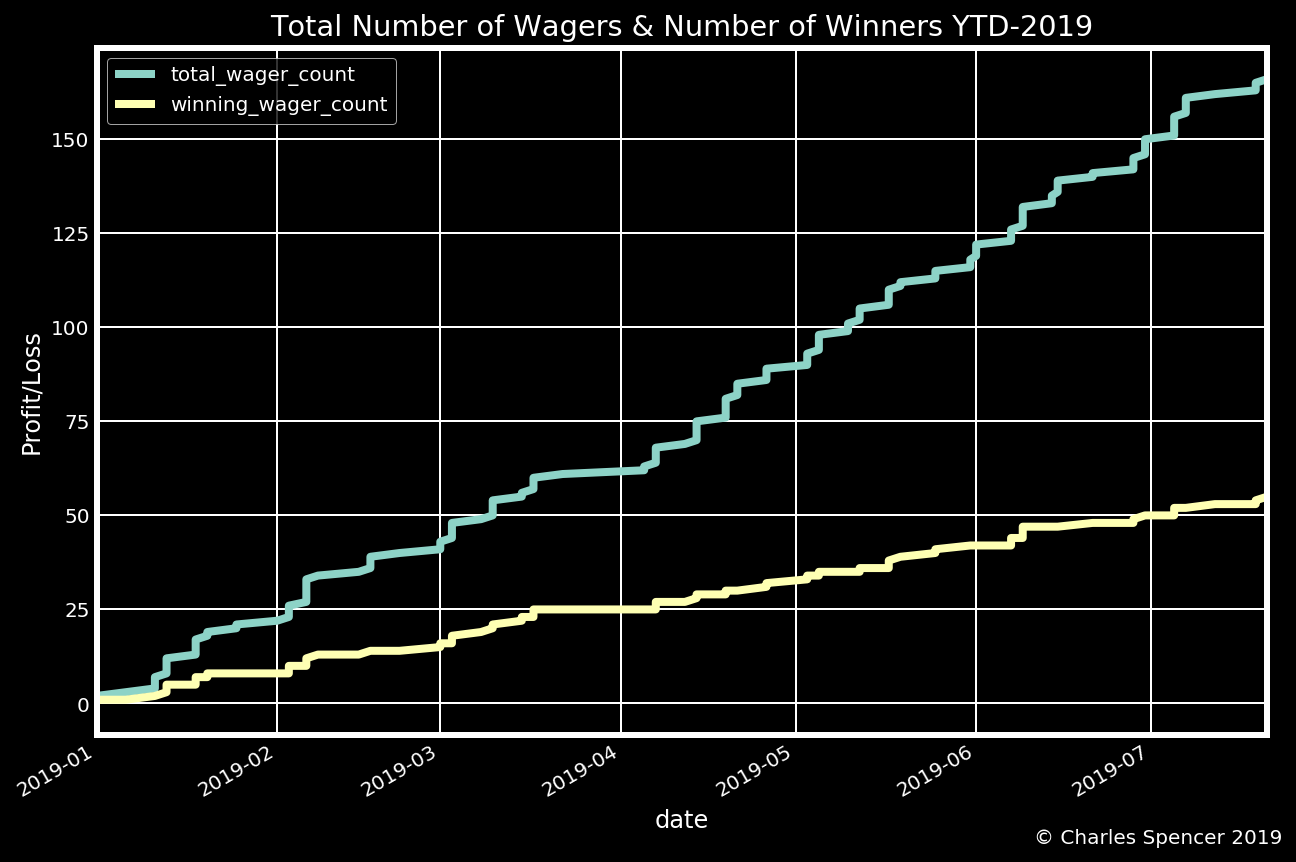

In [19]:
# Screen wagering on favorites which pay more than our fair odds (win_div_pred) results in these bets 
# of which nearly nearly 40% are winnners  

plt.style.use('dark_background')

x = 'date'
y = (['total_wager_count', 'winning_wager_count'])
accumualted_profit_loss.plot.line(x, y)
plt.title('Total Number of Wagers & Number of Winners YTD-2019')
plt.ylabel('Profit/Loss')
plt.gcf().set_size_inches(9, 6)
plt.grid(True)
plt.figtext(0.995, 0.01, u'\u00a9 Charles Spencer 2019', ha='right', va='bottom')
plt.tight_layout()


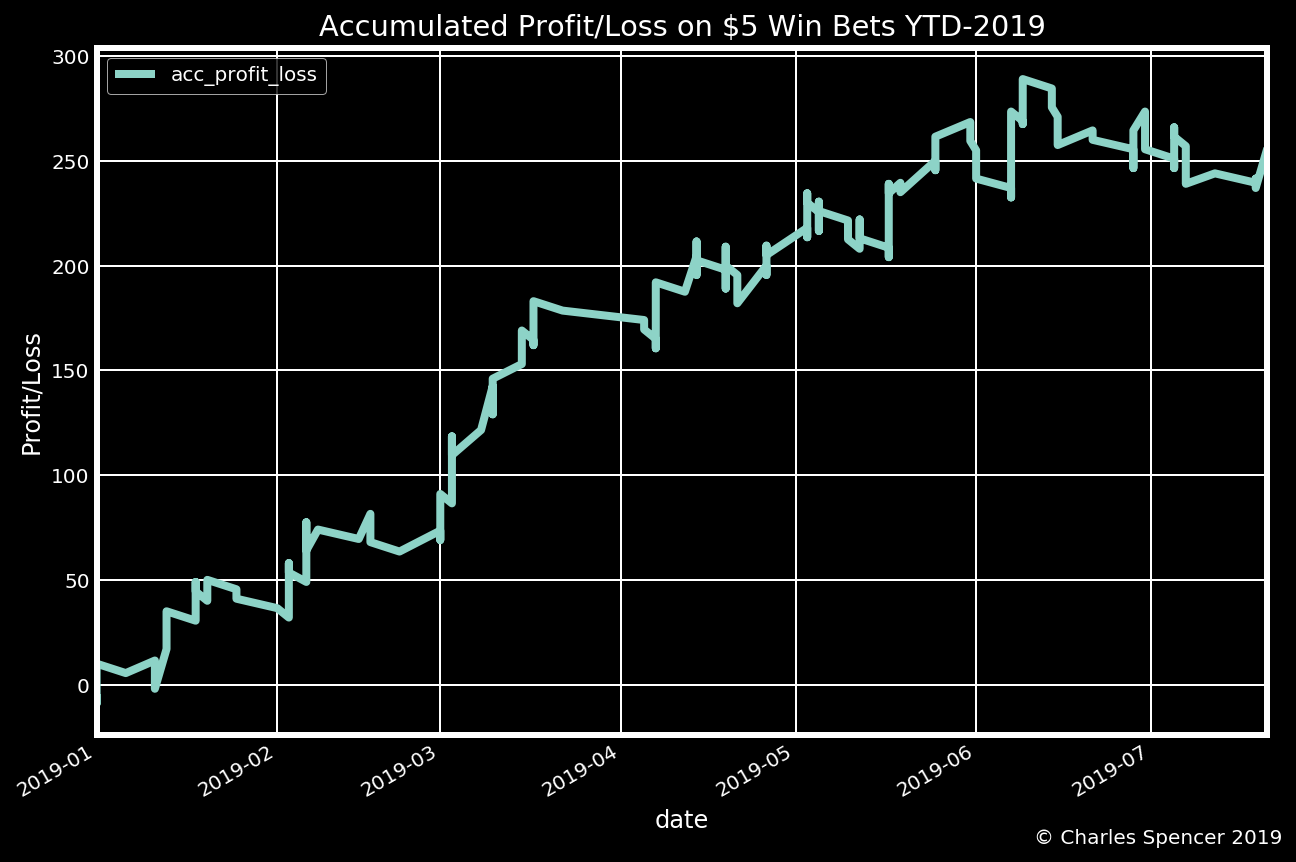

In [20]:
plt.style.use('dark_background')

accumualted_profit_loss.plot.line(x='date', y='acc_profit_loss')
plt.title('Accumulated Profit/Loss on $5 Win Bets YTD-2019')
plt.ylabel('Profit/Loss')
plt.gcf().set_size_inches(9, 6)
plt.grid(True)
plt.figtext(0.995, 0.01, u'\u00a9 Charles Spencer 2019', ha='right', va='bottom')
plt.tight_layout()


In [ ]:
accumualted_profit_loss[['win_count']].sum()